In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
from pyia import GaiaData
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

coord.galactocentric_frame_defaults.set('v4.0');

In [4]:
# run_name = '150pc_MG12-result'
run_name = 'clump-200pc-cube'
t = at.Table.read(f'../cache/probs-{run_name}.fits')
d = at.Table.read(f'../data/{run_name}.fits')
joined = at.join(d, t, keys='source_id', join_type='left')

g = GaiaData(joined[joined['prob'] > 0.5])
allg = GaiaData(joined)

---

# CMDs

In [5]:
mg = g.phot_g_mean_mag - g.distmod
bprp = g.phot_bp_mean_mag - g.phot_rp_mean_mag

In [6]:
iso = at.Table.read('/mnt/home/apricewhelan/data/isochrones/PARSEC/FeH_0.4_iso.fits')
iso = iso[np.isclose(iso['log(age/yr)'], 8.2)]
iso = iso[iso['stage'] < 2]

In [9]:
iso_interp = interp1d(iso['G'], iso['G_BP']-iso['G_RP'], bounds_error=False)

/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


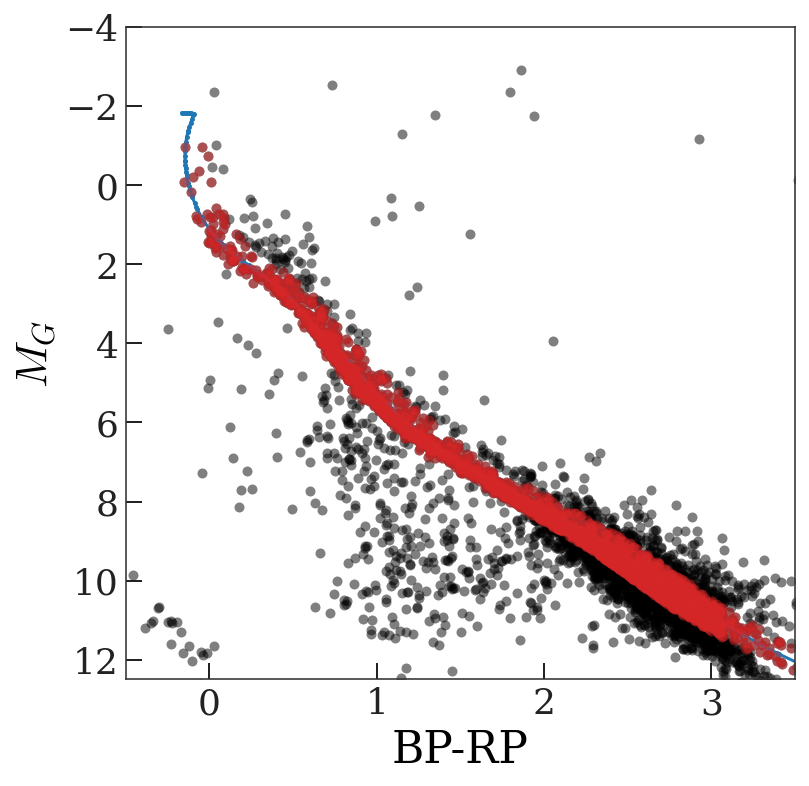

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(bprp, mg, marker='o', ls='none', alpha=0.5, mew=0)

ax.plot(iso['G_BP']-iso['G_RP'], iso['G'])

pred_bprp = iso_interp(mg.value)
cmd_mask = (np.abs(bprp.value - pred_bprp) < 0.15) #& (mg < 9*u.mag)
ax.plot(bprp[cmd_mask], mg[cmd_mask], 
        marker='o', ls='none', alpha=0.5, mew=0, color='tab:red')

ax.set_xlim(-0.5, 3.5)
ax.set_ylim(12.5, -4)

ax.set_xlabel('BP-RP')
ax.set_ylabel('$M_G$')

fig.set_facecolor('w')

In [11]:
c = g.get_skycoord()
gal = c.galactic

allc = allg.get_skycoord()
allgal = allc.galactic

In [12]:
xyz = gal.cartesian.xyz.to_value(u.pc)

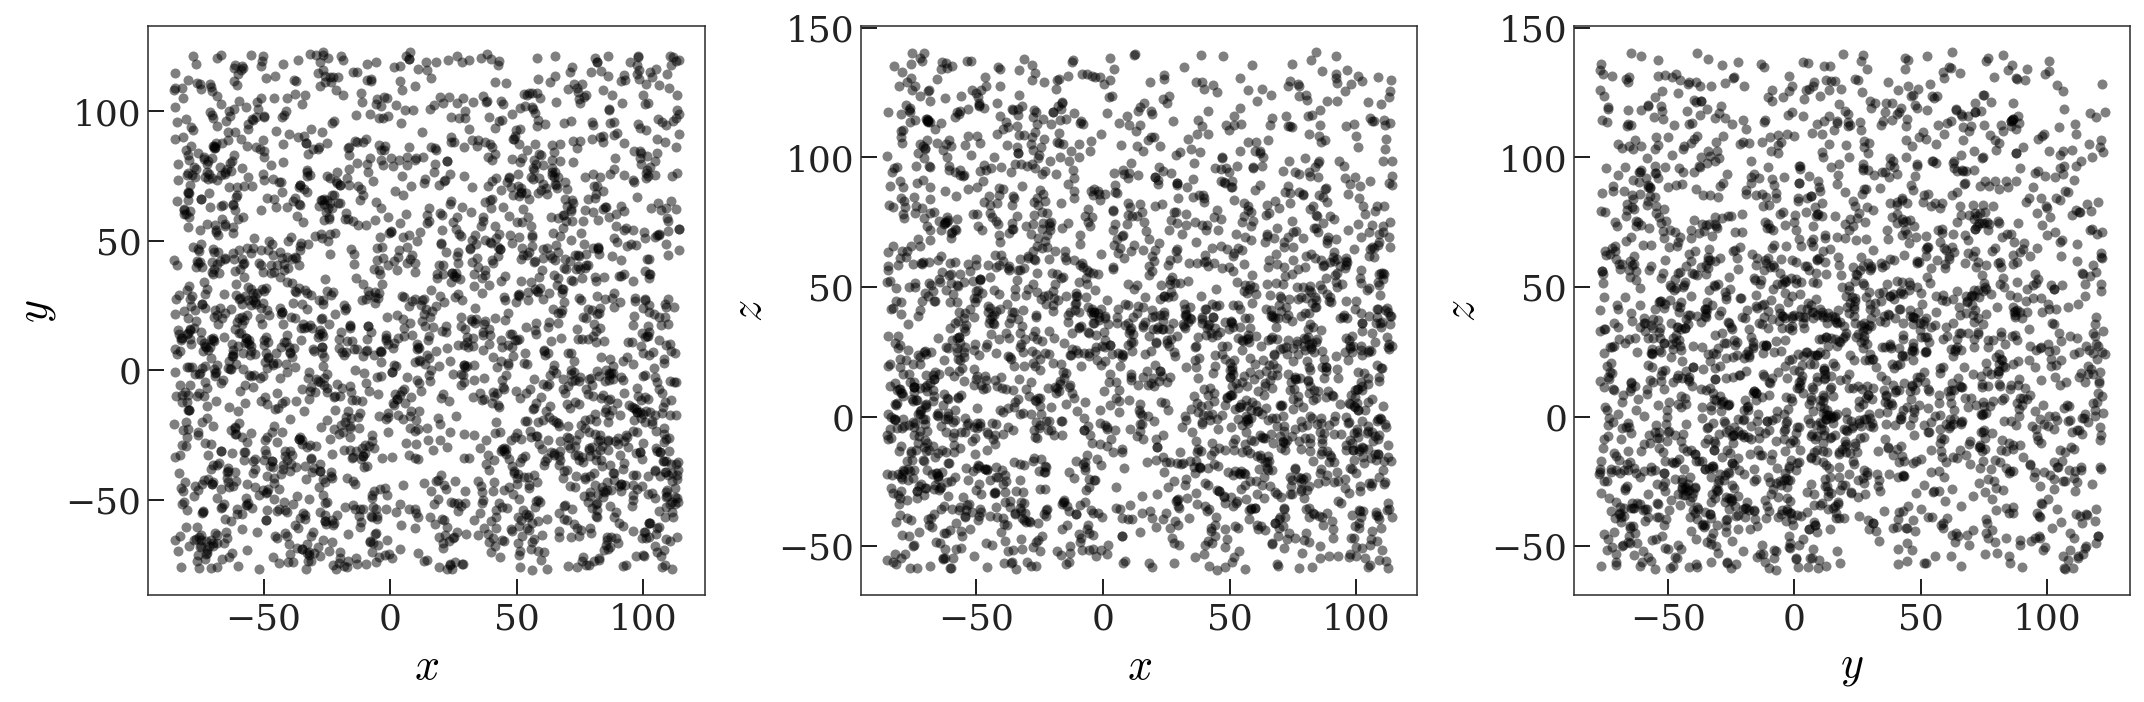

In [13]:
labels = ['x', 'y', 'z']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for k, (i, j) in enumerate([(0,1), (0,2), (1,2)]):
    ax = axes[k]

    ax.plot(xyz[i][cmd_mask],
            xyz[j][cmd_mask],
            marker='o', ls='none', mew=0, ms=5, alpha=0.5)

    ax.set_xlabel(f'${labels[i]}$')
    ax.set_ylabel(f'${labels[j]}$')
fig.tight_layout()
fig.set_facecolor('w')

In [14]:
allvxyz = allgal.velocity.d_xyz.to_value(u.km/u.s)
vxyz = gal.velocity.d_xyz.to_value(u.km/u.s)
vxyz = np.nanmedian(vxyz[:, cmd_mask], axis=1)
vxyz

array([-15.72440505, -20.77267169,  -3.99112539])

In [22]:
# control_v0 = np.array([15, 5, -2.5])
# derp = coord.SkyCoord(coord.CartesianRepresentation([10,10,10]*u.pc).with_differentials(coord.CartesianDifferential(control_v0*u.km/u.s)), 
#                       frame='icrs').galactic.velocity
# control_v0 = derp.d_xyz.value
# control_v0

control_v0 = np.array([-27, -10, -5])
derp = coord.SkyCoord(coord.CartesianRepresentation([10,10,10]*u.pc).with_differentials(coord.CartesianDifferential(control_v0*u.km/u.s)), 
                      frame='galactic').icrs.velocity
control_v0_icrs = derp.d_xyz.value
control_v0, control_v0_icrs

(array([-27, -10,  -5]), array([ 0.87887907, 29.0214793 ,  3.31380608]))

In [25]:
np.linalg.norm(vxyz), np.linalg.norm(control_v0_icrs)

(26.356970335147974, 29.22327839240492)

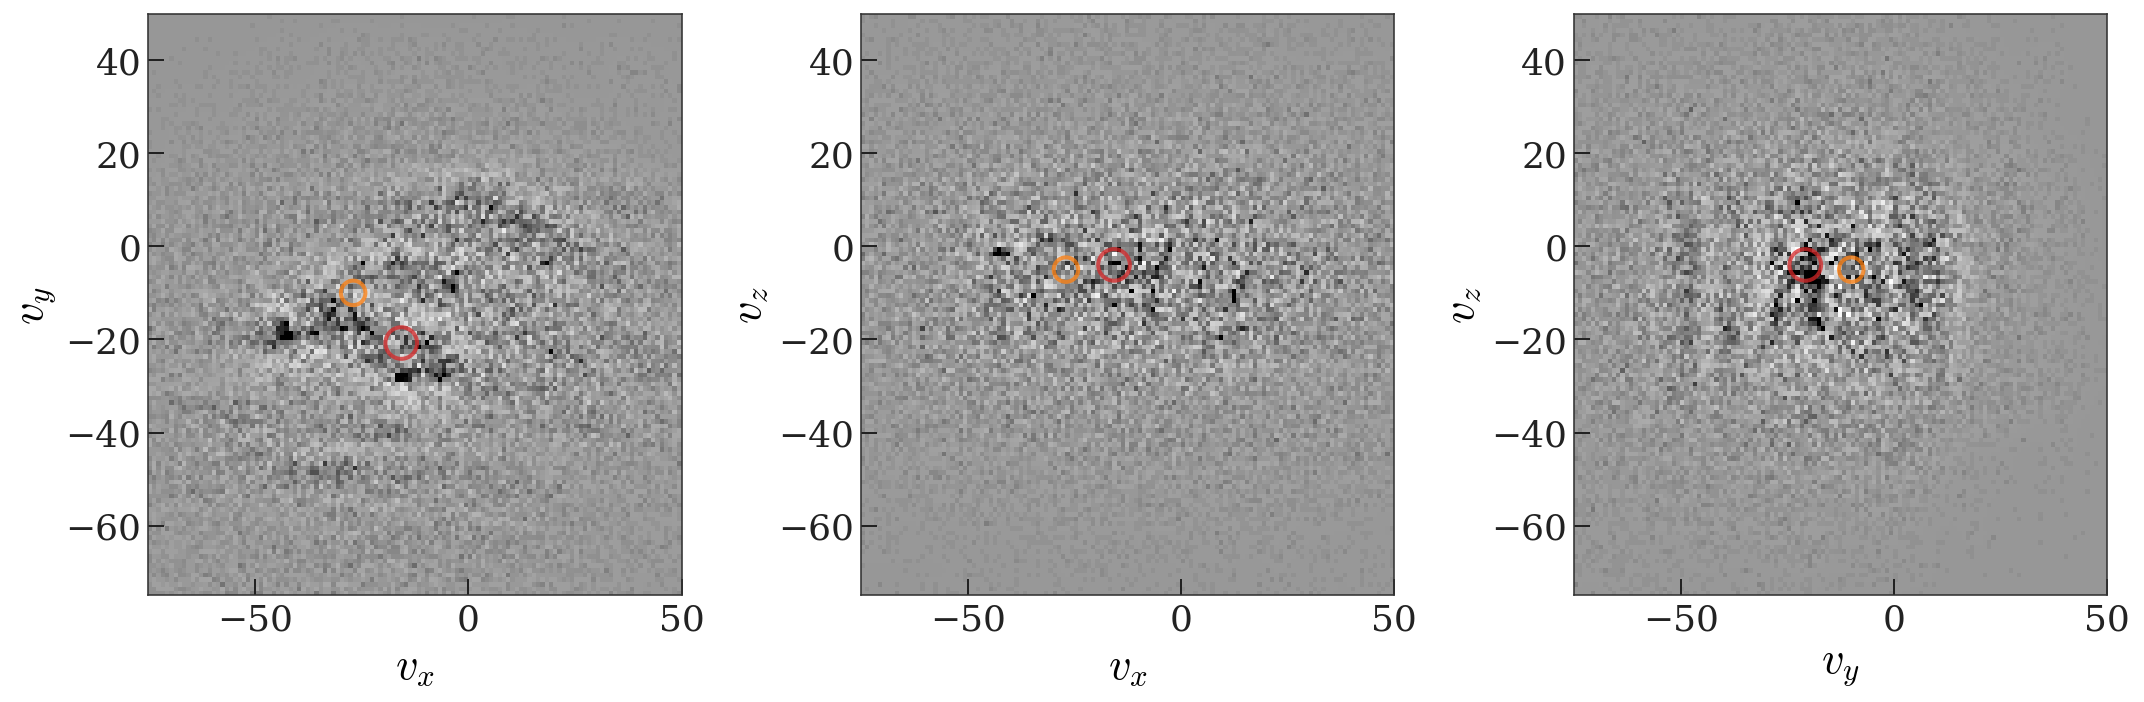

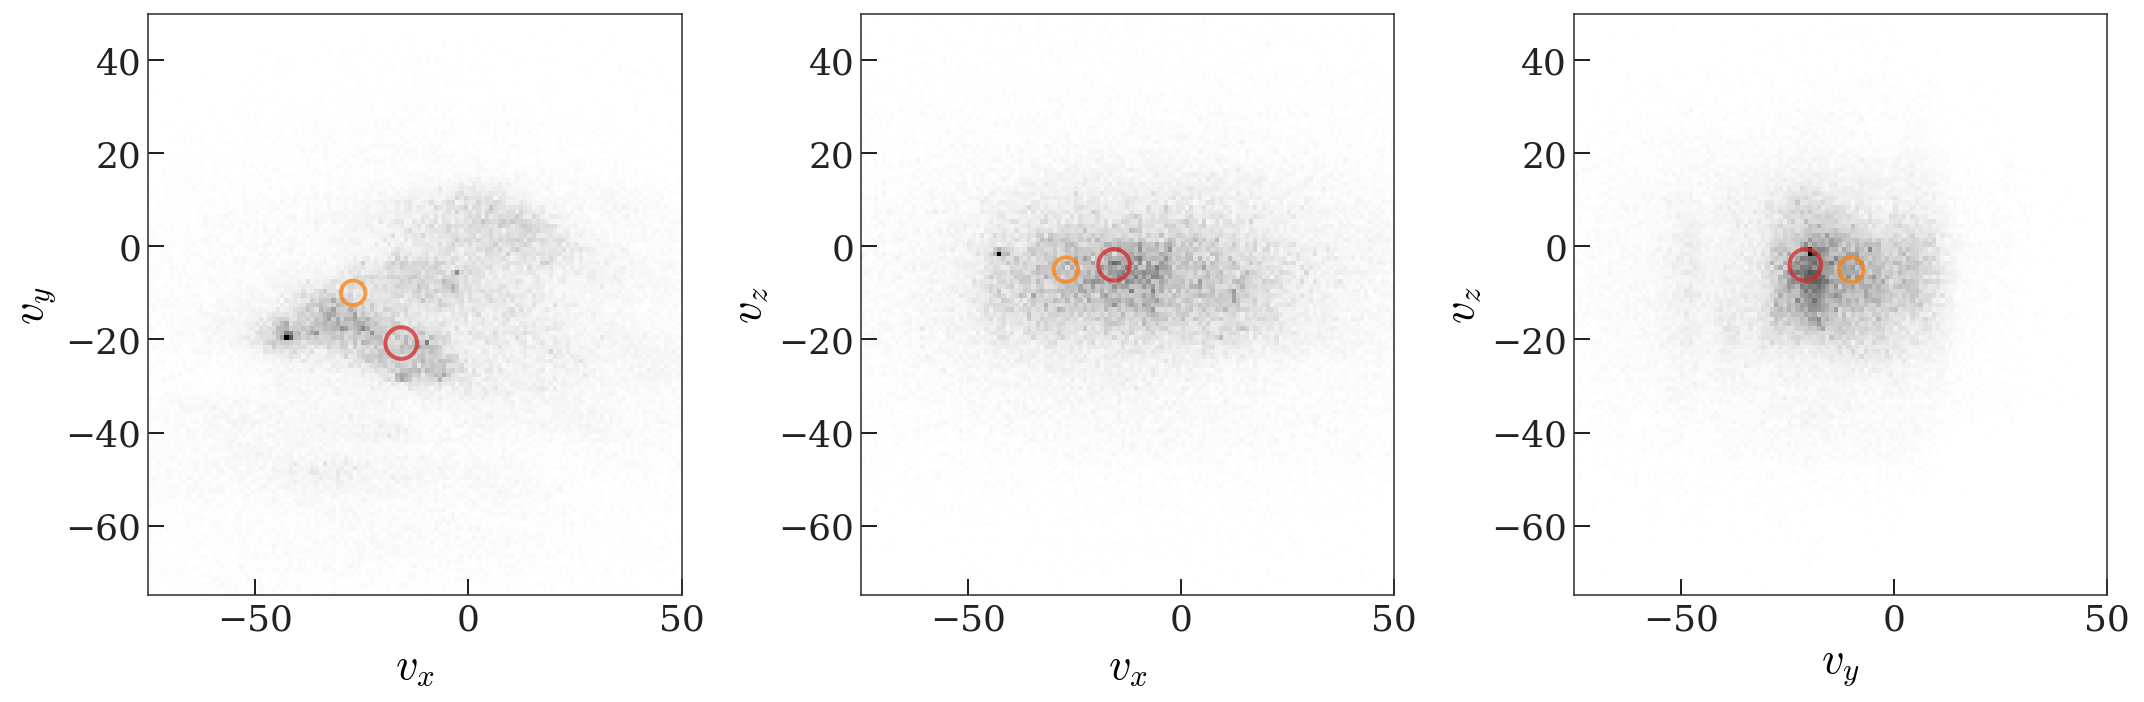

In [23]:
for cuddly in [True, False]:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for k, (i, j) in enumerate([(0,1), (0,2), (1,2)]):
        ax = axes[k]

        H, xe, ye = np.histogram2d(allvxyz[i],
                                   allvxyz[j],
                                   bins=np.arange(-75, 50+1e-3, 1))
        
#         ax.pcolormesh(xe, ye, H.T, 
#                       norm=mpl.colors.LogNorm(), cmap='Greys');
        if cuddly:
            H = H - gaussian_filter(H, sigma=3)
            ax.pcolormesh(xe, ye, H.T, cmap='Greys', vmin=-20, vmax=20)
        else:
            ax.pcolormesh(xe, ye, H.T, cmap='Greys')
        
        ax.scatter(vxyz[i], vxyz[j],
                   marker='o', zorder=100, linewidth=2, facecolor='none', 
                   alpha=0.75, s=250, edgecolor='tab:red')
        
        ax.scatter(control_v0[i],
                   control_v0[j],
                   marker='o', zorder=100, linewidth=2, facecolor='none', 
                   alpha=0.75, s=150, edgecolor='tab:orange')
            
        ax.set_xlabel(f'$v_{labels[i]}$')
        ax.set_ylabel(f'$v_{labels[j]}$')
    fig.tight_layout()
    fig.set_facecolor('w')

/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


21237
120
17125
159
9895
233


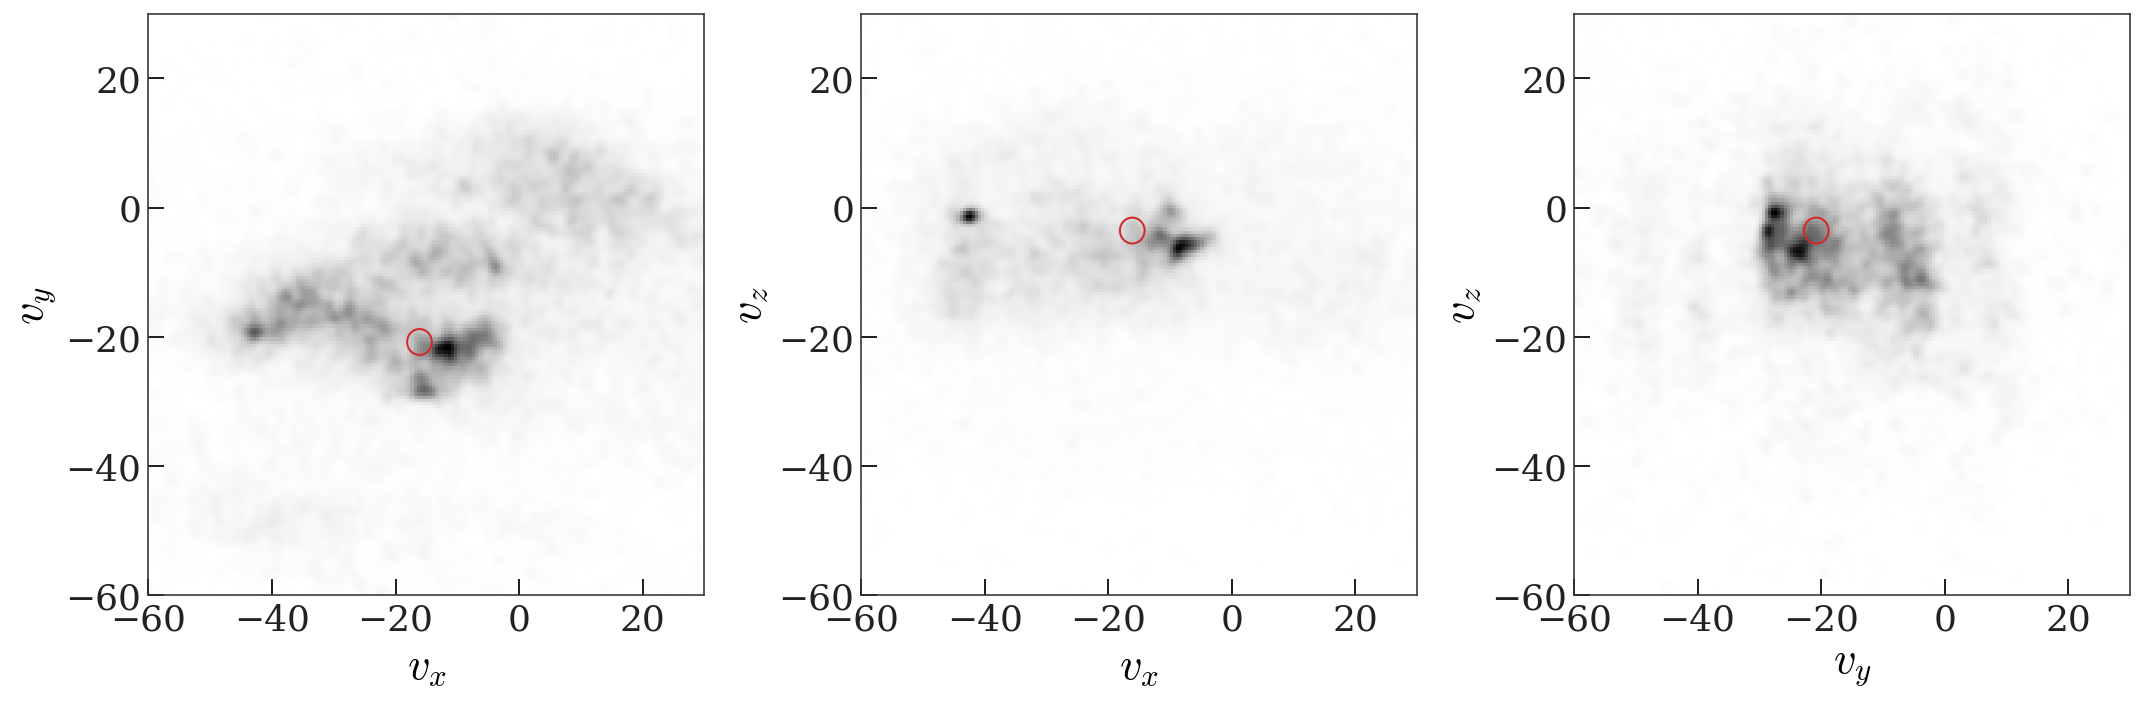

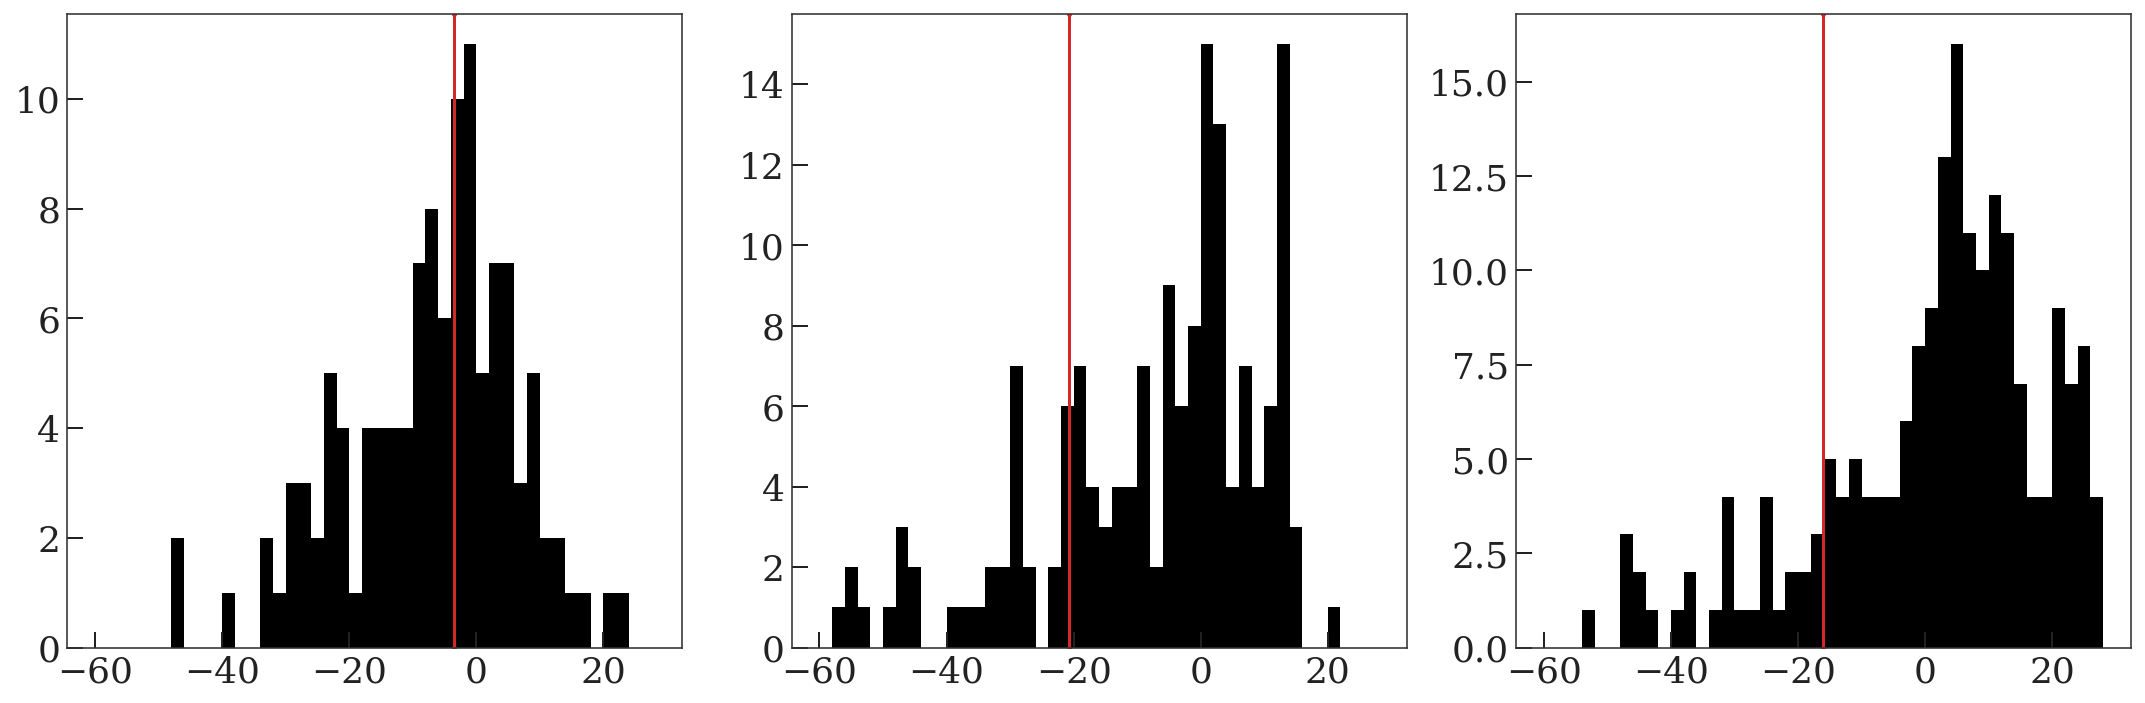

In [243]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

fig1d, axes1d = plt.subplots(1, 3, figsize=(15, 5))

not_in = [2, 1, 0]
for k, (i, j) in enumerate([(0,1), (0,2), (1,2)]):
    ax = axes[k]
    
    mask = np.abs(allvxyz[not_in[k]] - vxyz[not_in[k]]) < 2.
    print(mask.sum())
    H, xe, ye = np.histogram2d(allvxyz[i][mask],
                               allvxyz[j][mask],
                               bins=np.arange(-60, 30+1e-3, 0.5))
    H = gaussian_filter(H, sigma=1.5)
    ax.pcolormesh(xe, ye, H.T, cmap='Greys')
    
    circ = mpl.patches.Circle((vxyz[i], vxyz[j]),
                              radius=2, 
                              facecolor='none', edgecolor='tab:red', lw=1.)
    ax.add_patch(circ)
#     ax.scatter(vxyz[i], vxyz[j],
#                marker='o', zorder=100, linewidth=2, facecolor='none', 
#                alpha=0.75, s=250, edgecolor='tab:red')

    ax.set_xlabel(f'$v_{labels[i]}$')
    ax.set_ylabel(f'$v_{labels[j]}$')
    
    # --------------
    # 1D histograms:
    ax = axes1d[k]
    
    circ_mask = circ.get_path().contains_points(np.stack((allvxyz[i], allvxyz[j])).T)
    ax.hist(allvxyz[not_in[k]][circ_mask], bins=np.arange(-60, 30, 2))
    ax.axvline(vxyz[not_in[k]], color='tab:red')
    print(circ_mask.sum())
    
fig.tight_layout()
fig.set_facecolor('w')

fig1d.tight_layout()
fig1d.set_facecolor('w')

/cm/shared/sw/pkg/devel/python3/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


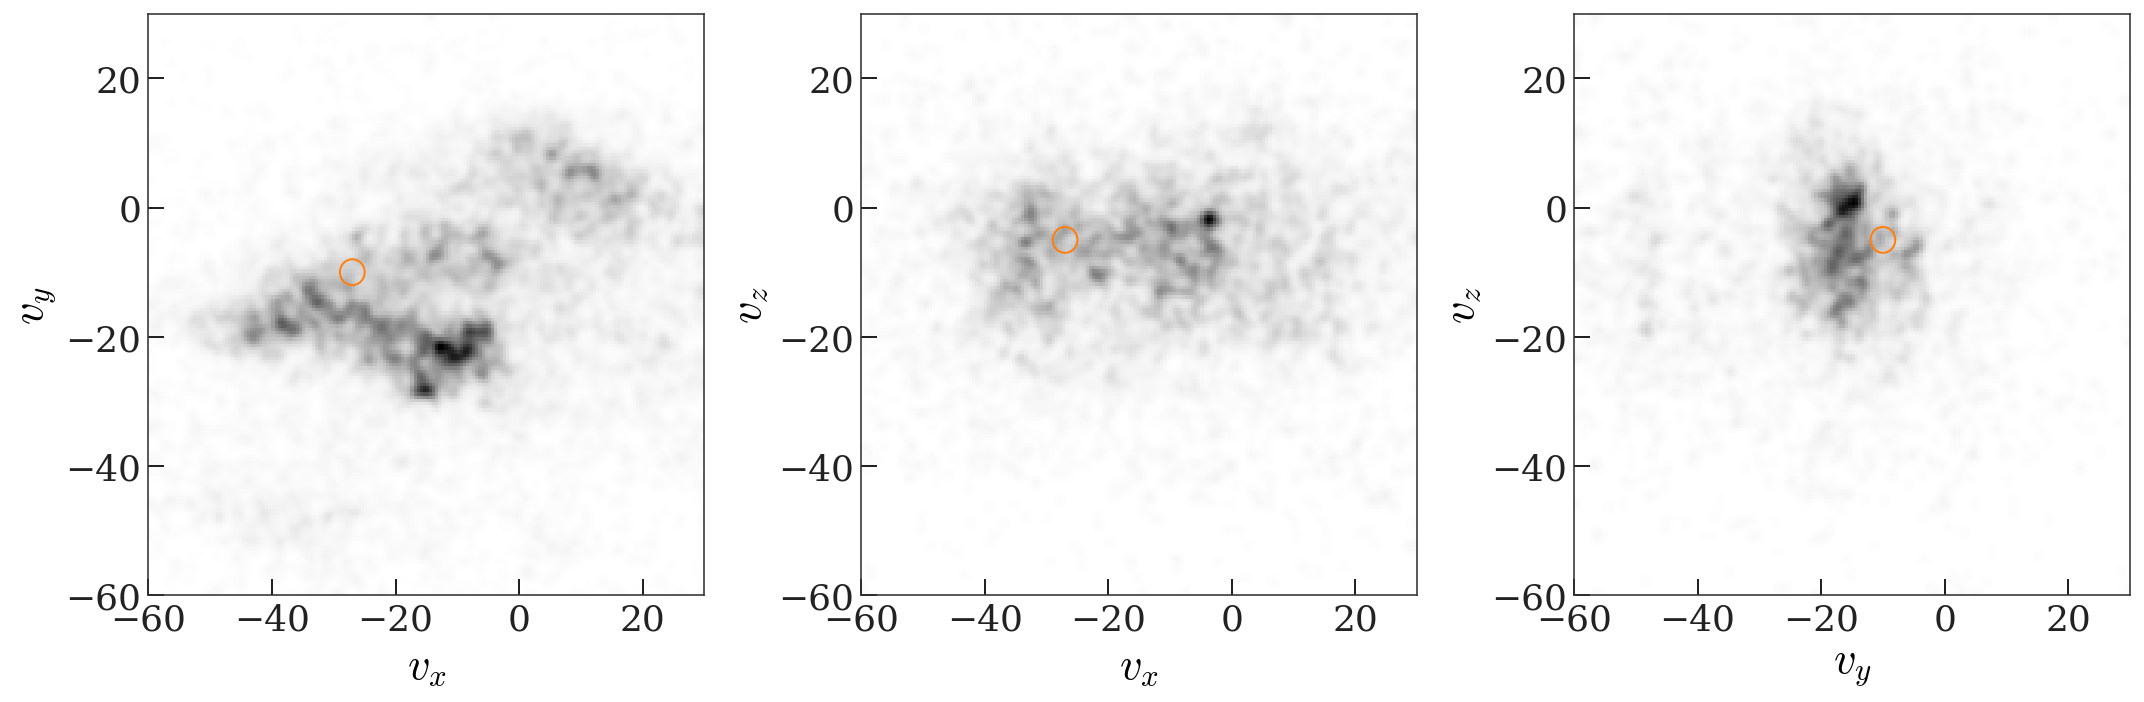

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

not_in = [2, 1, 0]
for k, (i, j) in enumerate([(0,1), (0,2), (1,2)]):
    ax = axes[k]
    
    mask = np.abs(allvxyz[not_in[k]] - control_v0[not_in[k]]) < 2.
    H, xe, ye = np.histogram2d(allvxyz[i][mask],
                               allvxyz[j][mask],
                               bins=np.arange(-60, 30+1e-3, 0.5))
    H = gaussian_filter(H, sigma=1.5)
    ax.pcolormesh(xe, ye, H.T, cmap='Greys')
    
    circ = mpl.patches.Circle((control_v0[i], control_v0[j]),
                              radius=2, 
                              facecolor='none', edgecolor='tab:orange', lw=1.)
    ax.add_patch(circ)

    ax.set_xlabel(f'$v_{labels[i]}$')
    ax.set_ylabel(f'$v_{labels[j]}$')
    
fig.tight_layout()
fig.set_facecolor('w')